# Potato Leaf Disease classification

This Notebook shows how to classify images of Potato Leaves Diseases. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`.

This Notebook follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [ ]:
import sys
sys.version

'3.7.10 (default, May  3 2021, 02:48:31) \n[GCC 7.5.0]'

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


## Upload and explore the dataset

we use a dataset of about 5,702 photos of Potato leaves. The dataset contains 3 sub-directories, one per class:

```
PotatoLeavesDiseaseDataSet/
  Earlyblight/
  Healthy/
  LateBlight/
```

## Upload PotatoLeavesDiseaseDataSet.zip using Colab File System

It will take some times depending on internet connection to upload dataset

In [ ]:
#check the directory
!ls -l

total 104656
-rw-r--r-- 1 root root 107158607 May 10 16:32 PotatoLeavesDiseaseDataSet.zip
drwxr-xr-x 1 root root      4096 May  6 13:44 sample_data


In [ ]:
#unzip the zip file
!unzip PotatoLeavesDiseaseDataSet.zip

Streaming output truncated to the last 5000 lines.
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/73d47ccd-4f15-4d93-90d1-5c35dbedd91e___RS_Early.B 7567_flipTB.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/74316ef6-7cce-4ed9-8fbf-9bf42d14657c___RS_Early.B 7352.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/74316ef6-7cce-4ed9-8fbf-9bf42d14657c___RS_Early.B 7352_180deg.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/74316ef6-7cce-4ed9-8fbf-9bf42d14657c___RS_Early.B 7352_flipTB.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/7456db33-766c-4a68-b924-ddf69d579981___RS_Early.B 6723_180deg.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/7486e823-64f7-4e43-ab51-26261b077fc2___RS_Early.B 6785.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/7486e823-64f7-4e43-ab51-26261b077fc2___RS_Early.B 6785_180deg.JPG  
  inflating: PotatoLeavesDiseaseDataSet/EarlyBlight/7486e823-64f7-4e43-ab51-26261b077fc2___RS_Early.B 6785_flipTB.JPG  
  i

In [ ]:
!ls -l

total 104660
drwxr-xr-x 5 root root      4096 May 10 16:32 PotatoLeavesDiseaseDataSet
-rw-r--r-- 1 root root 107158607 May 10 16:32 PotatoLeavesDiseaseDataSet.zip
drwxr-xr-x 1 root root      4096 May  6 13:44 sample_data


In [ ]:
#check present work directory
!pwd

/content


In [ ]:
#define data directory path
import pathlib
data_dir = pathlib.Path('/content/PotatoLeavesDiseaseDataSet/')

In [ ]:
data_dir

PosixPath('/content/PotatoLeavesDiseaseDataSet')

After uploading and unzipping, we should now have a copy of the dataset available. There are 5702 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

5702


Here are some Early Blight Disease of potato leaves:

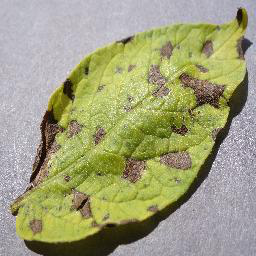

In [ ]:
early_blight = list(data_dir.glob('EarlyBlight/*'))
PIL.Image.open(str(early_blight[0]))

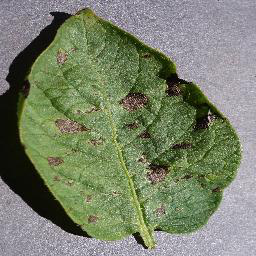

In [ ]:
PIL.Image.open(str(early_blight[1]))

And some Healthy Leaves:

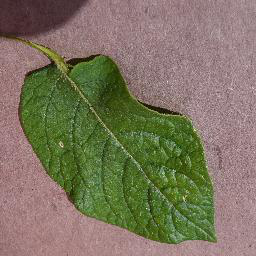

In [ ]:
healthy_leaf = list(data_dir.glob('Healthy/*'))
PIL.Image.open(str(healthy_leaf[0]))

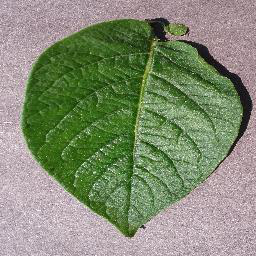

In [ ]:
PIL.Image.open(str(healthy_leaf[1]))

And some Late Blight Infected Leaves:

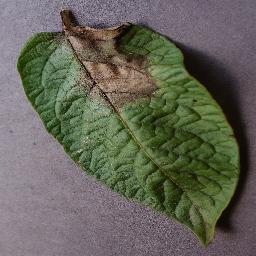

In [ ]:
late_blight_leaf = list(data_dir.glob('LateBlight/*'))
PIL.Image.open(str(late_blight_leaf[0]))

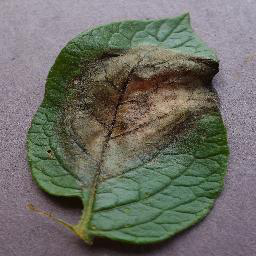

In [ ]:
PIL.Image.open(str(late_blight_leaf[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take us from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

## Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5702 files belonging to 3 classes.
Using 4562 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5702 files belonging to 3 classes.
Using 1140 files for validation.


We can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['EarlyBlight', 'Healthy', 'LateBlight']


## Visualize the data

Here are the first 9 images from the training dataset.

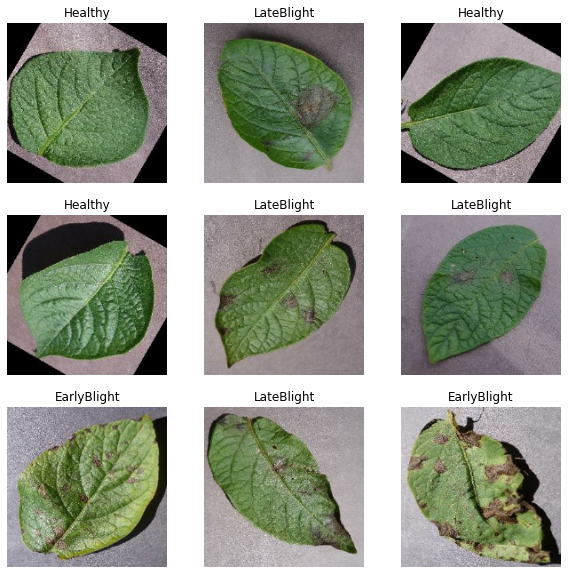

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We will train a model using these datasets by passing them to `model.fit` in a moment.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

we can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96620214


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this notebook is to show a standard approach. 

In [ ]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

 choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
143/143 [==============================] - 38s 57ms/step - loss: 0.7480 - accuracy: 0.6620 - val_loss: 0.1867 - val_accuracy: 0.9263
Epoch 2/15
143/143 [==============================] - 6s 41ms/step - loss: 0.1556 - accuracy: 0.9453 - val_loss: 0.1061 - val_accuracy: 0.9640
Epoch 3/15
143/143 [==============================] - 6s 42ms/step - loss: 0.1037 - accuracy: 0.9620 - val_loss: 0.0970 - val_accuracy: 0.9658
Epoch 4/15
143/143 [==============================] - 6s 41ms/step - loss: 0.0528 - accuracy: 0.9818 - val_loss: 0.0596 - val_accuracy: 0.9772
Epoch 5/15
143/143 [==============================] - 6s 41ms/step - loss: 0.0527 - accuracy: 0.9821 - val_loss: 0.1816 - val_accuracy: 0.9342
Epoch 6/15
143/143 [==============================] - 6s 42ms/step - loss: 0.0643 - accuracy: 0.9786 - val_loss: 0.0990 - val_accuracy: 0.9632
Epoch 7/15
143/143 [==============================] - 6s 42ms/step - loss: 0.0212 - accuracy: 0.9915 - val_loss: 0.0594 - val_accuracy: 0.975

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

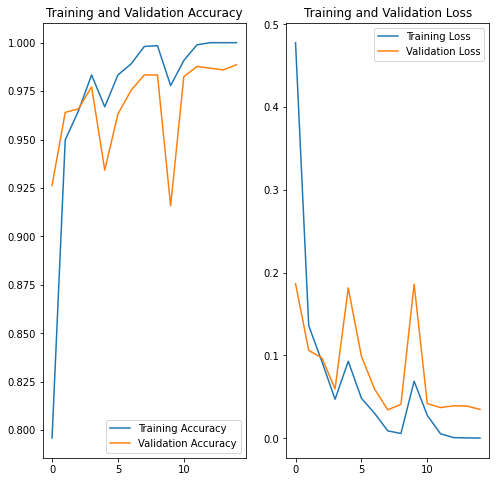

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by margin.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting



When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this Notebook, we will use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside our model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

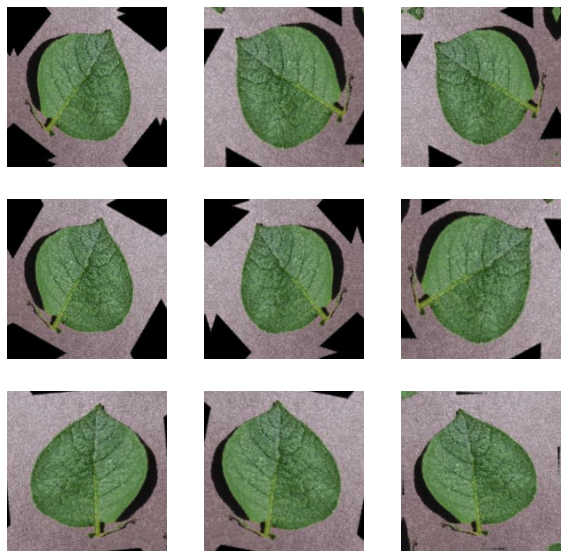

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
143/143 [==============================] - 8s 49ms/step - loss: 1.0131 - accuracy: 0.5290 - val_loss: 0.5117 - val_accuracy: 0.8316
Epoch 2/20
143/143 [==============================] - 7s 47ms/step - loss: 0.2581 - accuracy: 0.9047 - val_loss: 0.3049 - val_accuracy: 0.8860
Epoch 3/20
143/143 [==============================] - 7s 47ms/step - loss: 0.1261 - accuracy: 0.9550 - val_loss: 0.7197 - val_accuracy: 0.8474
Epoch 4/20
143/143 [==============================] - 7s 47ms/step - loss: 0.0958 - accuracy: 0.9652 - val_loss: 0.4088 - val_accuracy: 0.8886
Epoch 5/20
143/143 [==============================] - 7s 46ms/step - loss: 0.0528 - accuracy: 0.9818 - val_loss: 0.2867 - val_accuracy: 0.9316
Epoch 6/20
143/143 [==============================] - 7s 47ms/step - loss: 0.0866 - accuracy: 0.9685 - val_loss: 0.9637 - val_accuracy: 0.8079
Epoch 7/20
143/143 [==============================] - 7s 47ms/step - loss: 0.0804 - accuracy: 0.9654 - val_loss: 0.3096 - val_accuracy: 0.9123

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

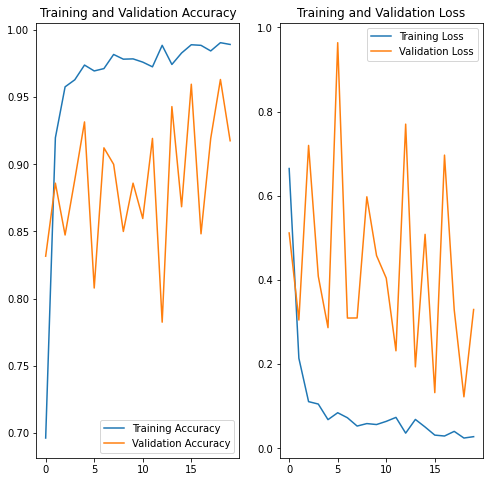

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

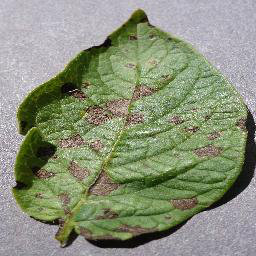

In [ ]:
PIL.Image.open(str('/content/PotatoLeavesDiseaseDataSet/early_blight.JPG'))

In [ ]:
early_blight_test = '/content/PotatoLeavesDiseaseDataSet/early_blight.JPG'

img = keras.preprocessing.image.load_img(
    early_blight_test, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to EarlyBlight with a 100.00 percent confidence.


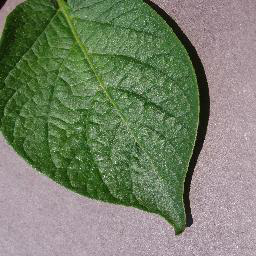

In [ ]:
PIL.Image.open(str('/content/PotatoLeavesDiseaseDataSet/healthy_leaf.JPG'))

In [ ]:
healthy_test = '/content/PotatoLeavesDiseaseDataSet/healthy_leaf.JPG'

img = keras.preprocessing.image.load_img(
    early_blight_test, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to EarlyBlight with a 100.00 percent confidence.


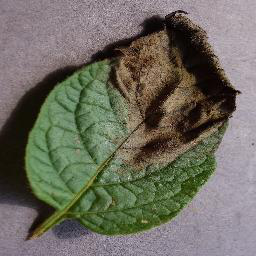

In [ ]:
PIL.Image.open(str('/content/PotatoLeavesDiseaseDataSet/late_blight.JPG'))

In [ ]:
late_blight_test = '/content/PotatoLeavesDiseaseDataSet/late_blight.JPG'

img = keras.preprocessing.image.load_img(
    late_blight_test, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to LateBlight with a 91.47 percent confidence.
